In [296]:
import torch

xs = []
for i in range(100):
    x = torch.load(f"/home/borth/GuidedResearch/data/dphm_kinect/christoph_mouthmove/params/{i:05}.pt")
    # x = torch.load(f"/home/borth/GuidedResearch/data/synthetic/s00005/params/{i:05}.pt")
    xs.append(x["neck_pose"])
xs = torch.cat(xs)
# (xs[1:] - xs[:-1]).mean()
xs[:, :5]

tensor([[-0.0921,  0.1095, -0.0521],
        [-0.0894,  0.1090, -0.0508],
        [-0.0914,  0.1135, -0.0513],
        [-0.0977,  0.1119, -0.0478],
        [-0.0931,  0.1095, -0.0540],
        [-0.0931,  0.1057, -0.0563],
        [-0.0955,  0.1093, -0.0511],
        [-0.0909,  0.1087, -0.0504],
        [-0.0930,  0.1100, -0.0520],
        [-0.0959,  0.1109, -0.0485],
        [-0.0946,  0.1100, -0.0529],
        [-0.0918,  0.1079, -0.0498],
        [-0.0906,  0.1038, -0.0482],
        [-0.0873,  0.1058, -0.0506],
        [-0.0845,  0.1048, -0.0512],
        [-0.0856,  0.1048, -0.0516],
        [-0.0827,  0.1043, -0.0508],
        [-0.0821,  0.1065, -0.0498],
        [-0.0826,  0.1047, -0.0518],
        [-0.0823,  0.1077, -0.0514],
        [-0.0854,  0.1101, -0.0472],
        [-0.0844,  0.1134, -0.0325],
        [-0.0814,  0.1141, -0.0321],
        [-0.0742,  0.1134, -0.0338],
        [-0.0852,  0.1195, -0.0358],
        [-0.0908,  0.1216, -0.0293],
        [-0.0954,  0.1141, -0.0251],
 

In [ ]:
import torch
from lib.optimizer.solver import PytorchCholeskySolver, LinearSystemSolver, PytorchSolver, PytorchLSTSQSolver

x = torch.load("/home/borth/GuidedResearch/temp/_tracked_innocenzo_fulgintl_rotatemouth/linsys/0000000.pt")
A = x["A"].requires_grad_(True)
b = x["b"].requires_grad_(True)
solver = PytorchLSTSQSolver()
x_gt, _ = solver(A, b)
x_gt.mean().backward()
print(A.grad.mean(), A.grad.median(), A.grad.max(), A.grad.min())
print(b.grad.mean(), b.grad.median(), b.grad.max(), b.grad.min())


In [ ]:
from lib.utils.config import load_config
from lib.optimizer.framework import OptimizerFramework, NeuralOptimizer
from lib.data.loader import load_intrinsics
import hydra
import torch
from lib.model.flame.flame import Flame
from lib.data.loader import load_intrinsics
from lib.rasterizer import Rasterizer
from lib.renderer.renderer import Renderer
from lib.renderer.camera import Camera

cfg = load_config("train", ["data=debug"])
K = load_intrinsics(data_dir=cfg.data.intrinsics_dir, return_tensor="pt")
camera = Camera(
    K=K,
    width=cfg.data.width,
    height=cfg.data.height,
    near=cfg.data.near,
    far=cfg.data.far,
    scale=cfg.data.scale,
)
rasterizer = Rasterizer(width=camera.width, height=camera.height)
renderer = Renderer(rasterizer=rasterizer, camera=camera)
flame = hydra.utils.instantiate(cfg.model)

datamodule = hydra.utils.instantiate(cfg.data, renderer=renderer)
datamodule.setup("fit")
dataloader = datamodule.train_dataloader()

path = "/home/borth/GuidedResearch/logs/2024-09-25/16-42-40_train/checkpoints/last.ckpt"
optimizer = NeuralOptimizer.load_from_checkpoint(path, renderer=renderer, flame=flame)
batch = next(iter(dataloader))
batch = optimizer.transfer_batch_to_device(batch, "cuda", 0)

In [ ]:
import time
optimizer.max_iters = 2
optimizer.max_optims = 1
optimizer.w_module = optimizer.default_w_module
s = time.time()
out = optimizer(batch)
(time.time() - s) * 1000

Creating GL context for cuda device 0
Successfully initialized EGL version 1.5
Successfully initialized OpenGL version 4.6.0 NVIDIA 535.183.01


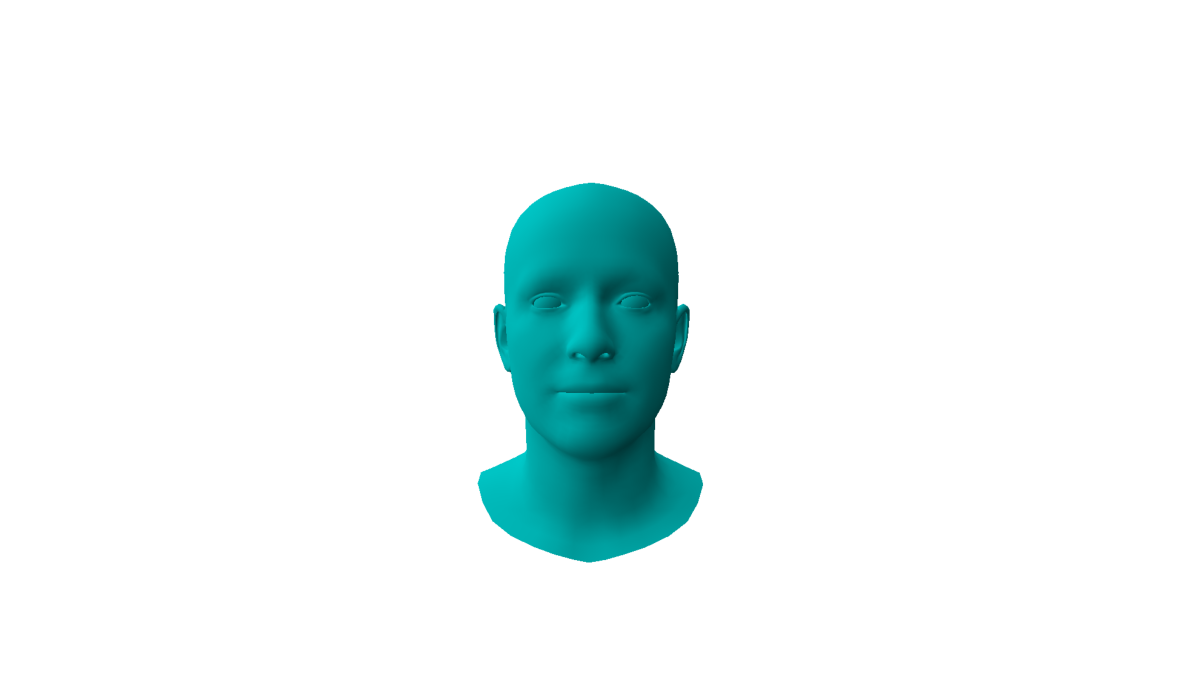

In [371]:
from lib.model.flame.flame import Flame
import torch
from lib.data.loader import load_intrinsics
from lib.rasterizer import Rasterizer
from lib.renderer.renderer import Renderer
from lib.renderer.camera import Camera
from lib.data.synthetic import generate_synthetic_params, generate_params
from lib.utils.visualize import visualize_grid, visualize_params

# settings
data_dir = "/home/borth/GuidedResearch/data/dphm_kinect/christoph_mouthmove"
flame_dir = "/home/borth/GuidedResearch/checkpoints/flame2023_no_jaw"
device = "cuda" if torch.cuda.is_available() else "cpu"

# setup camera, rasterizer and renderer
K = load_intrinsics(data_dir=data_dir, return_tensor="pt")
camera = Camera(K=K, width=1920, height=1080, scale=1)
rasterizer = Rasterizer(width=camera.width, height=camera.height)
renderer = Renderer(rasterizer=rasterizer, camera=camera)

# setup flame optimizer
flame = Flame(
    flame_dir=flame_dir,
    vertices_mask="full",
    expression_params=50,
    shape_params=100,
)

# creaste gt_params
params = generate_synthetic_params(
    flame,
    default=dict(transl=[0.0, 0.0, -0.45]),
    window_size=1,
    sigmas=dict(expression_params=1e-01),
    sparsity=dict(expression_params=0.0),
)
s_out = flame.render(renderer=renderer, params=params)
visualize_params(flame, renderer, params, color=0)